In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from dataset import COLORS,CityscapesFineDataset

In [2]:


# 🔧 Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🟢 Using GPU: {torch.cuda.get_device_name(0)}") if torch.cuda.is_available() else print("🟡 Using CPU")

batch_size = 4
num_classes = 19
epochs = 1
resize = (256, 512)
checkpoint_path = 'deeplabv3_cityscapes_best.pth'
best_val_loss = float('inf')



# 🔁 Transform con Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize(resize),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3, 0.3, 0.2, 0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(resize),
    transforms.ToTensor(),
])

# 📦 Dataset & Loader
root_dir = 'datasets/realcityscapes'
train_ds = CityscapesFineDataset(root=root_dir, split='train', transform=train_transform, resize=resize)
val_ds = CityscapesFineDataset(root=root_dir, split='val', transform=val_transform, resize=resize)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# 🧠 Modello + ottimizzatore + scheduler
model = deeplabv3_resnet50(pretrained=False, num_classes=num_classes).to(device)
model = model.to(memory_format=torch.channels_last)

for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.eval()  # evita drifting su batch piccoli

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
scaler = torch.cuda.amp.GradScaler()

start_epoch = 0

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scaler.load_state_dict(checkpoint['scaler'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))

    print(f"🔁 Ripreso da epoca {start_epoch}")
else:
    print("🆕 Nessun checkpoint trovato, si parte da zero.")

# 🏁 Training
for epoch in range(start_epoch, start_epoch+epochs):
    model.train()
    running_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs+start_epoch} [Train]")
    for images, masks in loop:
        images = images.to(device, memory_format=torch.channels_last, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        with torch.cuda.amp.autocast():
            out = model(images)['out']
            loss = criterion(out, masks)
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        loop.set_postfix(loss=running_loss/(loop.n+1))

    avg_train_loss = running_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1}: Avg Train Loss = {avg_train_loss:.4f}")

    # 📉 Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
            images = images.to(device)
            masks = masks.to(device)
            with torch.cuda.amp.autocast():
                out = model(images)['out']
                loss = criterion(out, masks)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    scheduler.step(avg_val_loss)
    print(f"📉 Avg Val Loss = {avg_val_loss:.4f}")

    # 💾 Salvataggio miglior modello
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scaler': scaler.state_dict(),
            'epoch': epoch,
            'best_val_loss': best_val_loss
        }, checkpoint_path)

        print("💾 Miglior modello salvato!")


🟢 Using GPU: NVIDIA GeForce RTX 4070


c:\Users\colam\Documents\GitHub\Proj11CV\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\colam\Documents\GitHub\Proj11CV\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\colam\AppData\Local\Temp\ipykernel_30024\2958784827.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\colam\AppData\Local\Temp\ipykernel_30024\2958784827.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module impli

🔁 Ripreso da epoca 28


Epoch 29/29 [Train]:   0%|          | 0/744 [00:00<?, ?it/s]C:\Users\colam\AppData\Local\Temp\ipykernel_30024\2958784827.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 29/29 [Train]: 100%|██████████| 744/744 [08:01<00:00,  1.54it/s, loss=0.444]


✅ Epoch 29: Avg Train Loss = 0.4440


Epoch 29/1 [Val]:   0%|          | 0/125 [00:00<?, ?it/s]C:\Users\colam\AppData\Local\Temp\ipykernel_30024\2958784827.py:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 29/1 [Val]: 100%|██████████| 125/125 [00:49<00:00,  2.55it/s]

📉 Avg Val Loss = 0.4540


🟢 Using: NVIDIA GeForce RTX 4070


C:\Users\colam\AppData\Local\Temp\ipykernel_30024\629012059.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


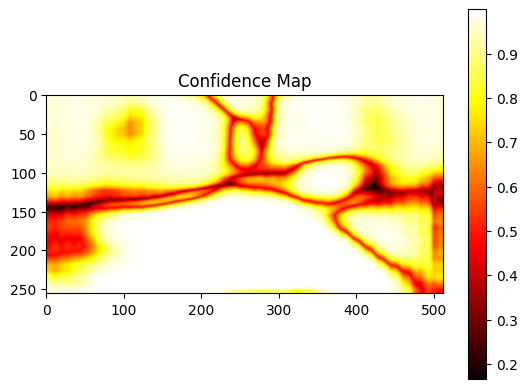

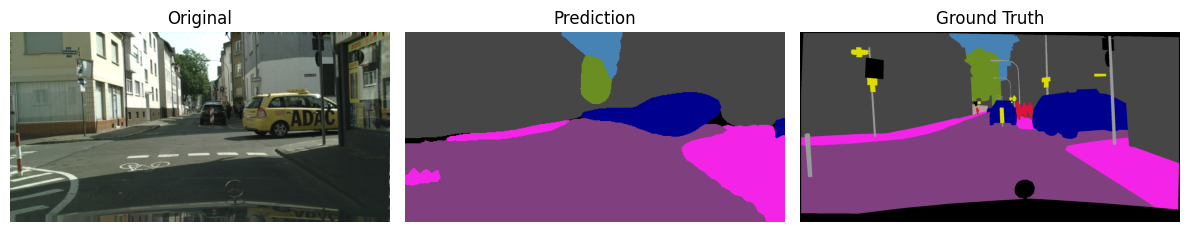

In [3]:
  # np.array shape (20, 3)

# 🔧 Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{'🟢' if torch.cuda.is_available() else '🟡'} Using: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

num_classes = 19
resize = (256, 512)
model_path = 'deeplabv3_cityscapes_best.pth'
image_path = 'datasets/realcityscapes/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png'
ground_image_path = 'datasets/realcityscapes/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_color.png'

# 🔁 Crea output_dir unico con timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = os.path.join('inference_outputs', f'infer_{timestamp}')
os.makedirs(output_dir, exist_ok=True)

# 🧠 Load model
model = deeplabv3_resnet50(pretrained=False, num_classes=num_classes).to(device)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model'])
model.eval()

# 🔁 Preprocessing
transform = transforms.Compose([
    transforms.Resize(resize),
    transforms.ToTensor(),
])

def decode_segmap(pred):
    h, w = pred.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for label in range(num_classes):
        color_mask[pred == label] = COLORS[label]
    return color_mask

def run_inference(image_path, ground_path=None):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)['out']
        output = torch.nn.functional.interpolate(output, size=resize, mode='bilinear', align_corners=False)

        probs = torch.softmax(output, dim=1)
        confidence, prediction = torch.max(probs, dim=1)

        prediction = prediction.squeeze(0).cpu().numpy()
        confidence = confidence.squeeze(0).cpu().numpy()

        threshold = 0.3
        ood_label = 19

        prediction_with_ood = prediction.copy()
        prediction_with_ood[confidence < threshold] = ood_label

        # Assicurati che COLORS abbia 20 colori
        seg_image = decode_segmap(prediction_with_ood)


    # 📸 Salvataggio immagini
    base_name = os.path.splitext(os.path.basename(image_path))[0]

    Image.fromarray(seg_image).save(os.path.join(output_dir, f"{base_name}_pred.png"))
    image.save(os.path.join(output_dir, f"{base_name}_original.png"))

    if ground_path:
        gt = Image.open(ground_path)
        gt.save(os.path.join(output_dir, f"{base_name}_gt.png"))


    from matplotlib import cm
    conf_img = (confidence * 255).astype(np.uint8)
    Image.fromarray(conf_img).save('confidence_map.png')

    plt.imshow(confidence, cmap='hot')
    plt.title('Confidence Map')
    plt.colorbar()
    plt.show()

    # 📊 Visualizzazione
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Prediction")
    plt.imshow(seg_image)
    plt.axis('off')

    if ground_path:
        plt.subplot(1, 3, 3)
        plt.title("Ground Truth")
        plt.imshow(gt)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{base_name}_all.png"))
    plt.show()

# 🚀 Run
run_inference(image_path, ground_image_path)
